In [25]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas


def visualize_converge(MODELS_TO_CHOOSE, LABELS):
    fig = plt.figure(figsize=(16, 6), dpi=100)

    axes = fig.subplots(2,2, sharex='col', sharey='row')

    # ax1.set_xticks(np.linspace(min(result_df.index), max(result_df.index), num=5, dtype=int))
    #     ax1.set_xticklabels(np.linspace(min(result_df.index)+1, max(result_df.index)+1, num=5 , dtype=int))
    # axe for loss
    #ax2 = ax1.twinx()

    COLORS = ['teal', 'orange', '#e87a59', 'red',  'green', 'yellow',]

    ALPHAS = [0.5, 0.5, 0.5, 0.5, 1]#np.linspace(0.1, 1, num=len(MODELS_TO_CHOOSE), dtype=float)

    for j in range(len(axes)): # num of columns in a row
        label = LABELS[j]
        
        for i, MODEL in enumerate(MODELS_TO_CHOOSE):
            result_df = pandas.read_csv(f'result_data/{MODEL}_{label}.csv')
            sns.lineplot(data=result_df, x='iteration', y='accuracy', label=f'{MODEL}', color=COLORS[i], alpha=ALPHAS[i], ax=axes[0][j], linestyle='-', linewidth=2,)
            sns.lineplot(data=result_df, x='iteration', y='loss', label=f'{MODEL}', color=COLORS[i], alpha=ALPHAS[i], ax=axes[1][j], linestyle='-', linewidth=2)

        if label== "1":
            axes[0][j].set_title('Positive Examples')
            axes[1][j].set_title('Positive Examples')
        elif label == "0":
            axes[0][j].set_title('Negative Examples')
            axes[1][j].set_title('Negative Examples')
        axes[0][j].legend([],[], frameon=False)
        axes[1][j].legend([],[], frameon=False)
        axes[0][j].set_ylabel('Accuracy')
        axes[0][j].set_xlabel('Iteration')
        axes[1][j].set_ylabel('Loss')
        axes[1][j].set_xlabel('Iteration')


    handles, labels = axes[0][1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right')
    plt.show()


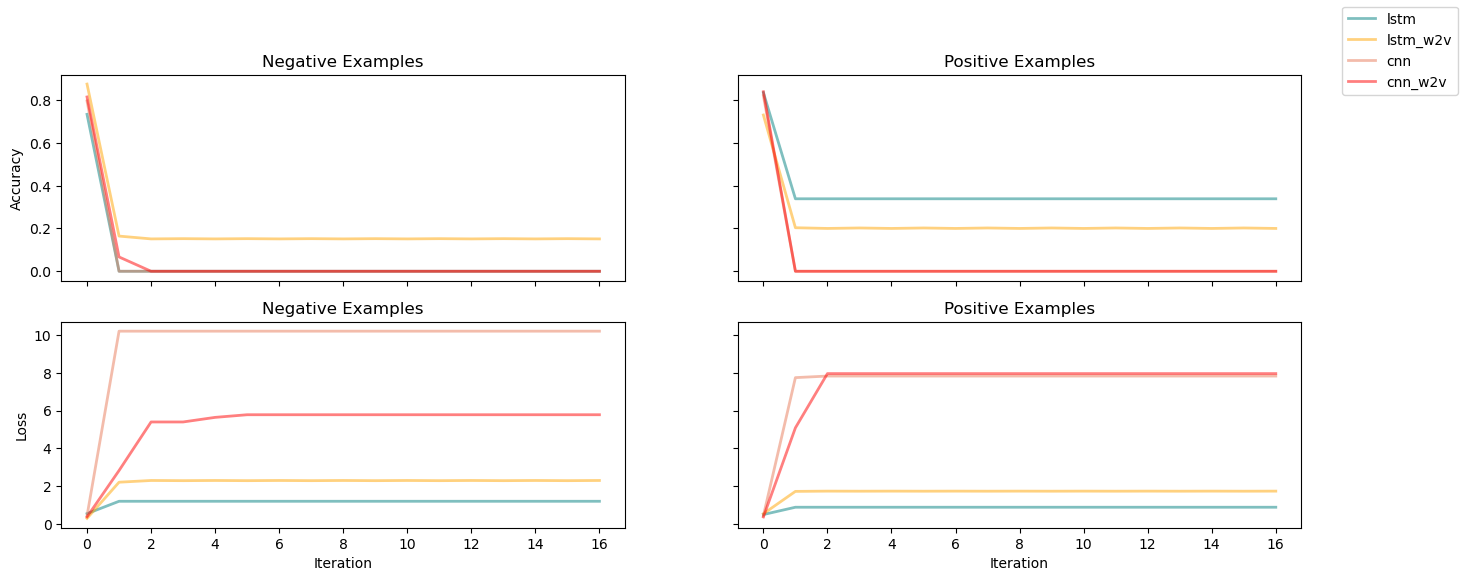

In [26]:
MODELS_TO_CHOOSE = ['lstm', 'lstm_w2v', 'cnn', 'cnn_w2v', ] #'cnn_tanh', 'finetuned_bert'
LABELS = ["0", "1"]
visualize_converge(MODELS_TO_CHOOSE, LABELS)

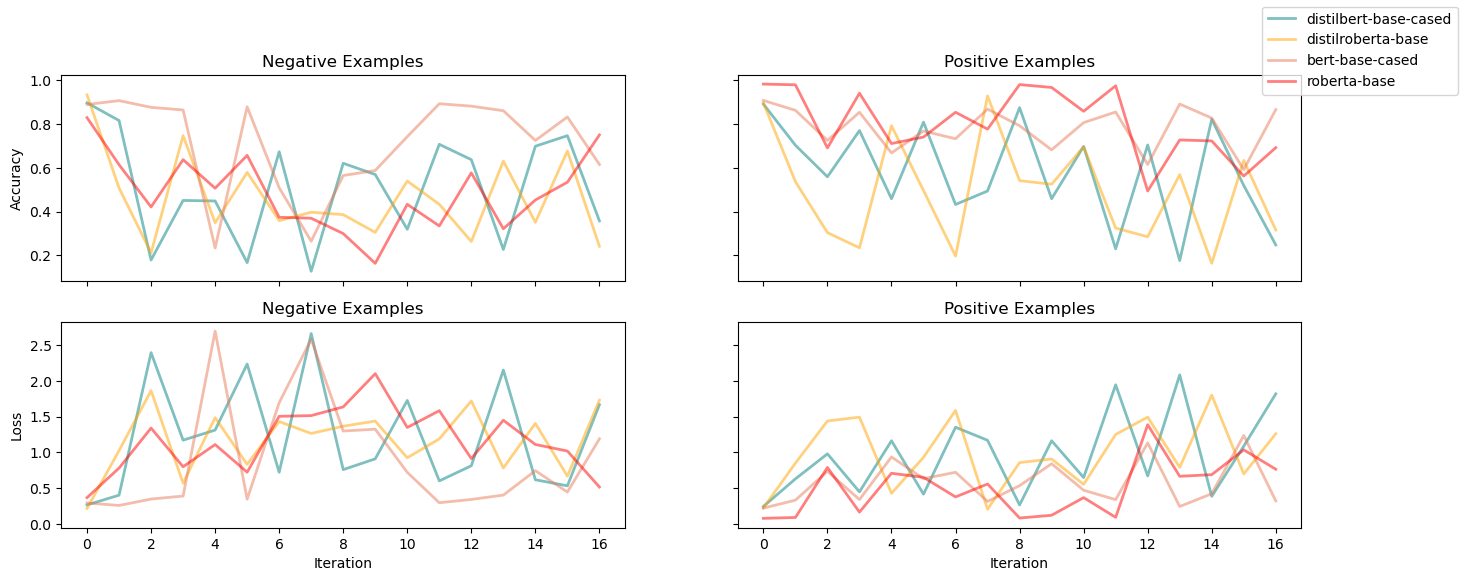

In [27]:
MODELS_TO_CHOOSE = ['distilbert-base-cased',  'distilroberta-base', 'bert-base-cased', 'roberta-base',  ] #'cnn_tanh', 'finetuned_bert'
LABELS = ["0", "1"]
visualize_converge(MODELS_TO_CHOOSE, LABELS)

# Trigger Diversity


In [15]:
from allennlp.data.tokenizers import Token
import pandas as pd
from utils.allennlp_model import load_sst_model
from utils.allennlp_predictor import AttackPredictorForBiClassification
from utils.allennlp_data import load_sst_data
import torch

# get triggers
def get_triggers(MODEL, label, last_trigger=False):
    """

    return:
        trigger_tokens [List(Token)]
    """

    result_df = pd.read_csv(f'result_data/{MODEL_TYPE}_{label}.csv')[['iteration', 'triggers', 'accuracy','loss']]

    if last_trigger:
        trigger_tokens = list(result_df['triggers'])[-1] # only evaluate on the last one
        acc = list(result_df['accuracy'])[-1]
    else:
        trigger_tokens = result_df['triggers'][result_df['loss'].argmax()]
        acc = result_df['accuracy'][result_df['loss'].argmax()]

    trigger_tokens = [Token(trigger) for trigger in trigger_tokens.split('_')]
    
    return trigger_tokens, acc

In [40]:
MODELS_TO_CHOOSE = ['cnn_w2v', 'cnn', 'lstm_w2v', 'lstm', 'distilbert-base-cased',  'distilroberta-base', 'bert-base-cased', 'roberta-base', ]

LABELS = [0,1]
result = []
for MODEL_TYPE in MODELS_TO_CHOOSE:
    datareader, test_data = load_sst_data('test', MODEL_TYPE, granularity = str(2)+'-class')
    vocab, model = load_sst_model(f"checkpoints/bi_sst/{MODEL_TYPE}/",  MODEL_TYPE=MODEL_TYPE)
    # get embedding matrix 
    predictor = AttackPredictorForBiClassification(model, datareader)
    embedding_matrix = predictor.get_interpretable_layer()
    embedding_matrix = embedding_matrix.weight

    # get embeddings of triggers and calculate cosine similarity
    cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
    for label in LABELS:
        trigger_tokens, acc = get_triggers(MODEL_TYPE, label = label, last_trigger=False)
        if 'bert' in MODEL_TYPE:
            trigger_token_ids = [vocab.get_token_index(str(trigger_tokens[i]), namespace='tags') for i in range(len(trigger_tokens))]
        else:
            trigger_token_ids = [vocab.get_token_index(str(trigger_tokens[i]), namespace='tokens') for i in range(len(trigger_tokens))]
        word_embedding = torch.nn.functional.embedding(torch.LongTensor(trigger_token_ids), embedding_matrix.cpu())
        cos = torch.nn.CosineSimilarity(dim=-1, eps=1e-6)
        diversity_score = 1- cos(word_embedding[0], word_embedding[1]) * cos(word_embedding[1], word_embedding[2]) * cos(word_embedding[0], word_embedding[2])
        trigger_tokens_str = [str(token) for token in trigger_tokens]
        ttr = len(set(trigger_tokens_str))
        output_triggers = '-'.join(trigger_tokens_str)
        result.append([MODEL_TYPE, label, output_triggers, diversity_score.item(),ttr, acc])




In [41]:
from IPython.core.display import HTML
df_result = pd.DataFrame(result)
df_result.columns=['Model', 'Class', 'Triggers', 'Diversity', 'TTR', 'Accuracy']
df_result.set_index('Model')

,Class,Triggers,Diversity,TTR,Accuracy
Model,,,,,
cnn_w2v,0,infuses-captivating-heartwarming,0.956434,3,0.000000
cnn_w2v,1,unengaging-unengaging-unengaging,0.000000,1,0.000000
cnn,0,solid-solid-solid,0.000000,1,0.000000
cnn,1,suffers-stupid-stupid,0.091698,2,0.000000
lstm_w2v,0,heartwarming-joyful-joyful,0.728696,2,0.151316
lstm_w2v,1,unwatchable-unwatchable-uninspired,0.812578,2,0.200220
lstm,0,solid-solid-solid,0.000000,1,0.000000
lstm,1,too-too-too,0.000000,1,0.338834
distilbert-base-cased,0,beautifully-stunning-stunning,0.605161,2,0.127193


# Adversarial Transferability

In [ ]:
import pandas as pd
import torch

                       distilbert-base-cased  bert-base-cased  roberta-base  \
Generated by                                                                  
bert-base-cased                     0.293860         0.286184      0.755482   
distilbert-base-cased               0.118421         0.357456      0.752193   
distilroberta-base                  0.907895         0.922149      0.316886   
roberta-base                        0.892544         0.912281      0.171053   

                       distilroberta-base  
Generated by                               
bert-base-cased                  0.928728  
distilbert-base-cased            0.940789  
distilroberta-base               0.228070  
roberta-base                     0.508772  


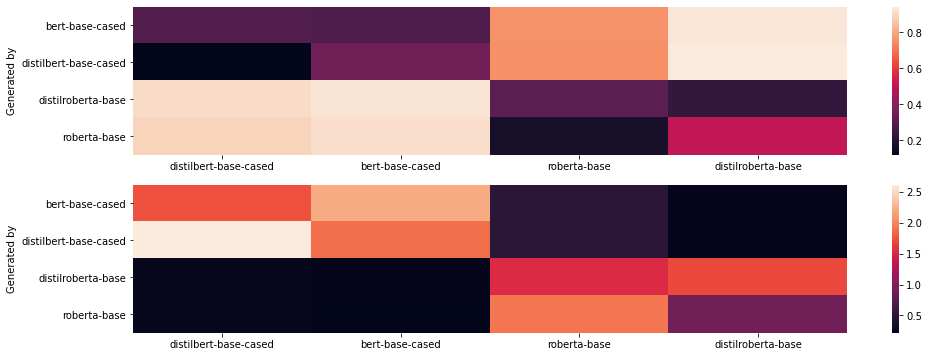

In [18]:

EXPERIMENT_VERSION_CODE = 'distill'
label = 0

df_acc = pd.read_csv(f'result_data/transfer_acc_{EXPERIMENT_VERSION_CODE}_{str(label)}.csv', index_col=0)
df_loss =pd.read_csv(f'result_data/transfer_loss_{EXPERIMENT_VERSION_CODE}_{str(label)}.csv', index_col=0)
print(df_acc)
# print(df_loss)
figure = plt.figure(figsize=(16, 6))
axes = figure.subplots(2, 1)
sns.heatmap(df_acc, ax=axes[0])
sns.heatmap(df_loss, ax=axes[1])
plt.show()